In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
import os
import sys
from pathlib import Path
from tqdm import tqdm

from scipy.stats import boxcox

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

ERA_DATA_PATH = str(HOME / 'system_tests/data/ERA5')

from cgan.data import VAR_NAME_LOOKUP_ERA5, get_era5_filepath_prefix, get_era5_path, get_imerg_path, load_era5_month

In [6]:
# Check that the stats code works
ds = xr.open_dataset(get_era5_path('u', year=2020, month=11, era_data_dir=ERA_DATA_PATH))

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# load a year of ERA5
year = 2016

all_dates = list(pd.date_range(start=f'{year}-01-01', end=f'{year}-12-01', freq='M'))
all_dates = [item.date() for item in all_dates]

var_name_lookup=VAR_NAME_LOOKUP_ERA5

latitude_vals=np.arange(-12, 16, 1)
longitude_vals=np.arange(25, 50, 1)

sample_vals = {}

for variable in tqdm(VAR_NAME_LOOKUP_ERA5, total=len(VAR_NAME_LOOKUP_ERA5)):
    
    # Turn off normalisation for the moment
    var_name_lookup[variable]['normalisation'] = None
    
    datasets = []
    for date in all_dates:
        year = date.year
        month = date.month
        tmp_ds = load_era5_month(variable, year, month, latitude_vals=latitude_vals,
                                longitude_vals=longitude_vals, var_name_lookup=var_name_lookup)

        datasets.append(tmp_ds)
    concat_ds = xr.concat(datasets, dim='time')

    sample_vals[variable] = concat_ds[variable].values.flatten()

100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


234500


<AxesSubplot:ylabel='Density'>

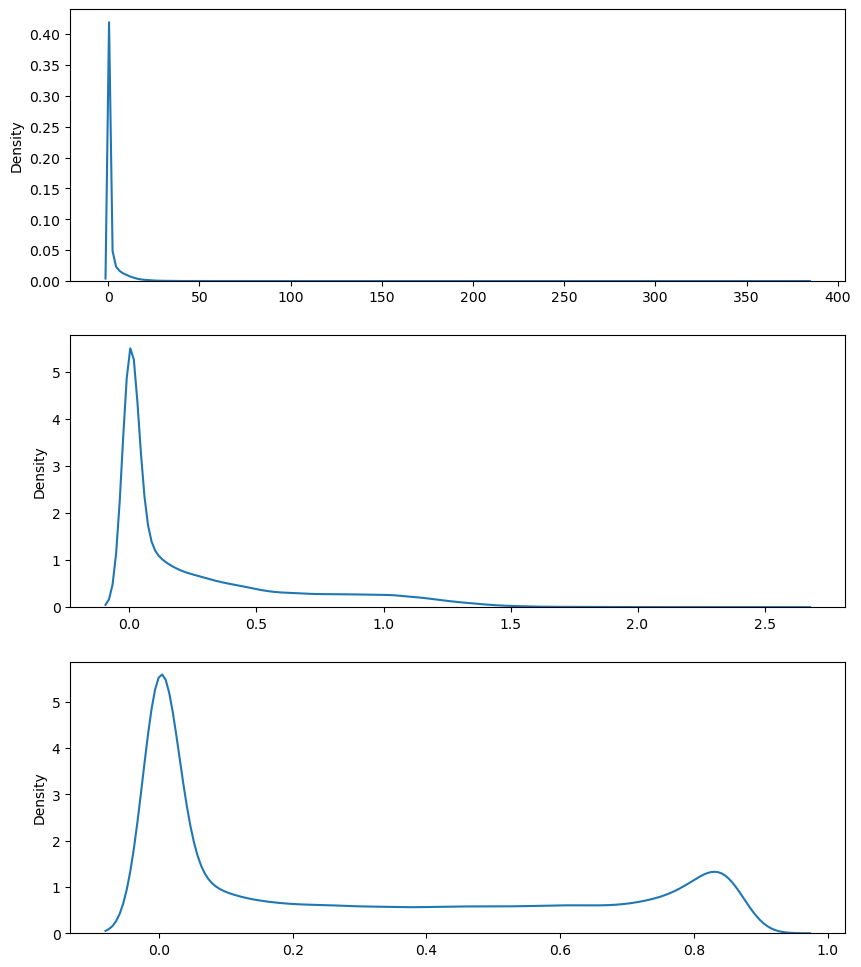

In [55]:
fig, ax = plt.subplots(3, 1, figsize = (10, 12))
sample_precipitation = sample_vals['tp']
sns.kdeplot(data=sample_precipitation, ax=ax[0])
print(len(sample_precipitation))

# Try with logged tp
sns.kdeplot(data=np.log10(1 + sample_precipitation), ax=ax[1])

# Try box cox (in two stages to make sure we're getting correct value of lambda)
_, lmxle = boxcox(1 + sample_precipitation)
sns.kdeplot(data=boxcox(1 + sample_precipitation, lmbda=lmxle), ax=ax[2])


234500


<AxesSubplot:ylabel='Density'>

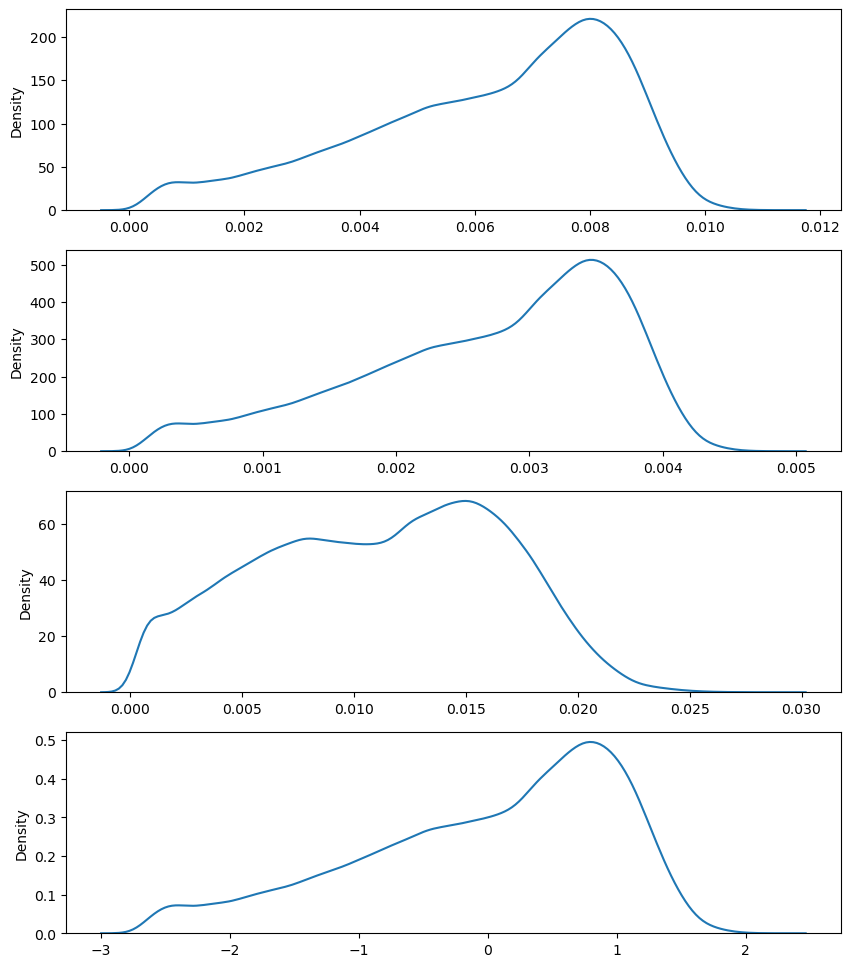

In [70]:
fig, ax = plt.subplots(4, 1, figsize = (10, 12))
sample = sample_vals['q']
sns.kdeplot(data=sample, ax=ax[0])
print(len(sample))

# Try with logged tp
sns.kdeplot(data=np.log10(1 + sample), ax=ax[1])

# Try box cox (in two stages to make sure we're getting correct value of lambda)
_, lmxle = boxcox(1 + sample)
sns.kdeplot(data=boxcox(1 + sample, lmbda=lmxle), ax=ax[2])

# try standardised
sns.kdeplot(data=(sample - sample.mean())/sample.std(), ax=ax[3])


234500


/user/work/uz22147/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/user/work/uz22147/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


<AxesSubplot:ylabel='Density'>

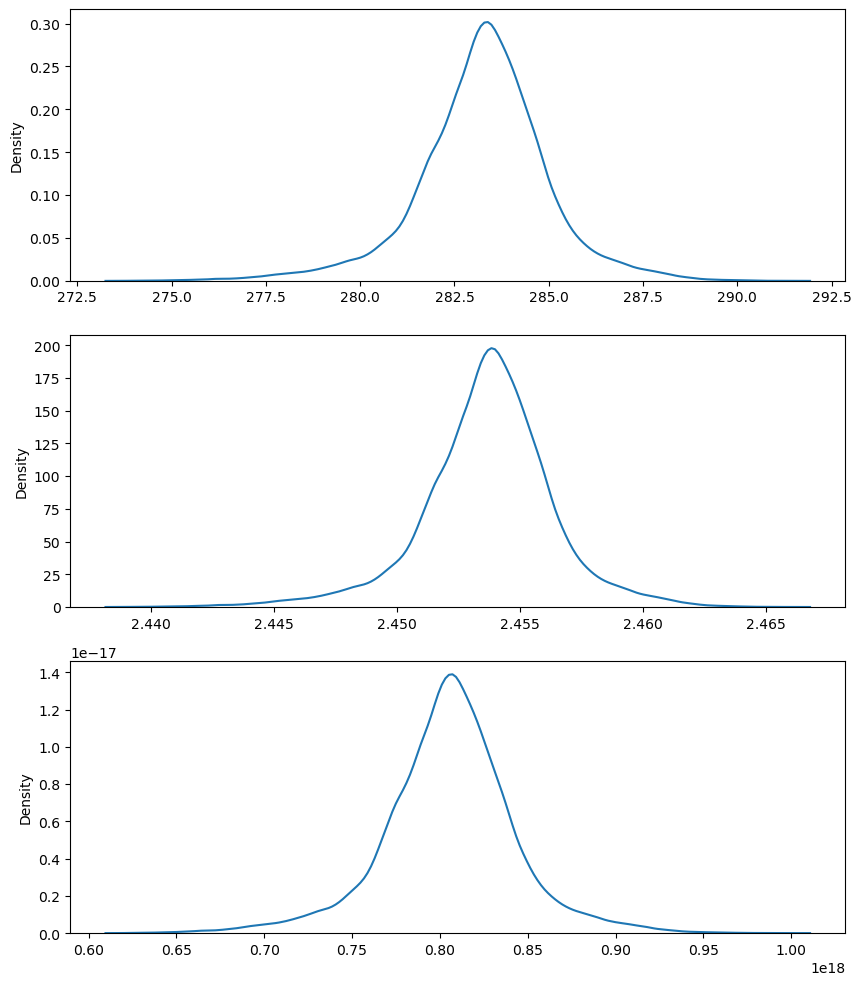

In [57]:
fig, ax = plt.subplots(3, 1, figsize = (10, 12))
sample = sample_vals['t']
sns.kdeplot(data=sample, ax=ax[0])
print(len(sample))

# Try with logged tp
sns.kdeplot(data=np.log10(1 + sample), ax=ax[1])

# Try box cox (in two stages to make sure we're getting correct value of lambda)
_, lmxle = boxcox(1 + sample)
sns.kdeplot(data=boxcox(1 + sample, lmbda=lmxle), ax=ax[2])

234500


<AxesSubplot:ylabel='Density'>

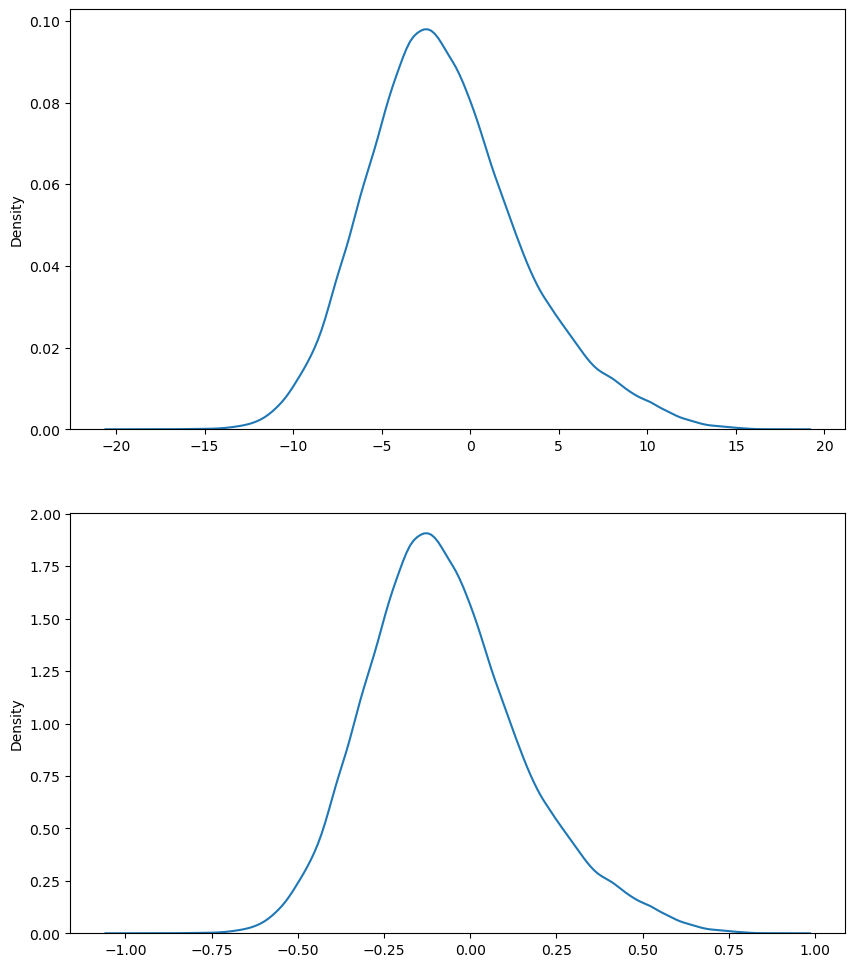

In [66]:
fig, ax = plt.subplots(2, 1, figsize = (10, 12))
sample = sample_vals['u']
sns.kdeplot(data=sample, ax=ax[0])
print(len(sample))

sns.kdeplot(data=(sample - np.abs(sample).min())/np.abs(sample).max(), ax=ax[1])

234500


<AxesSubplot:ylabel='Density'>

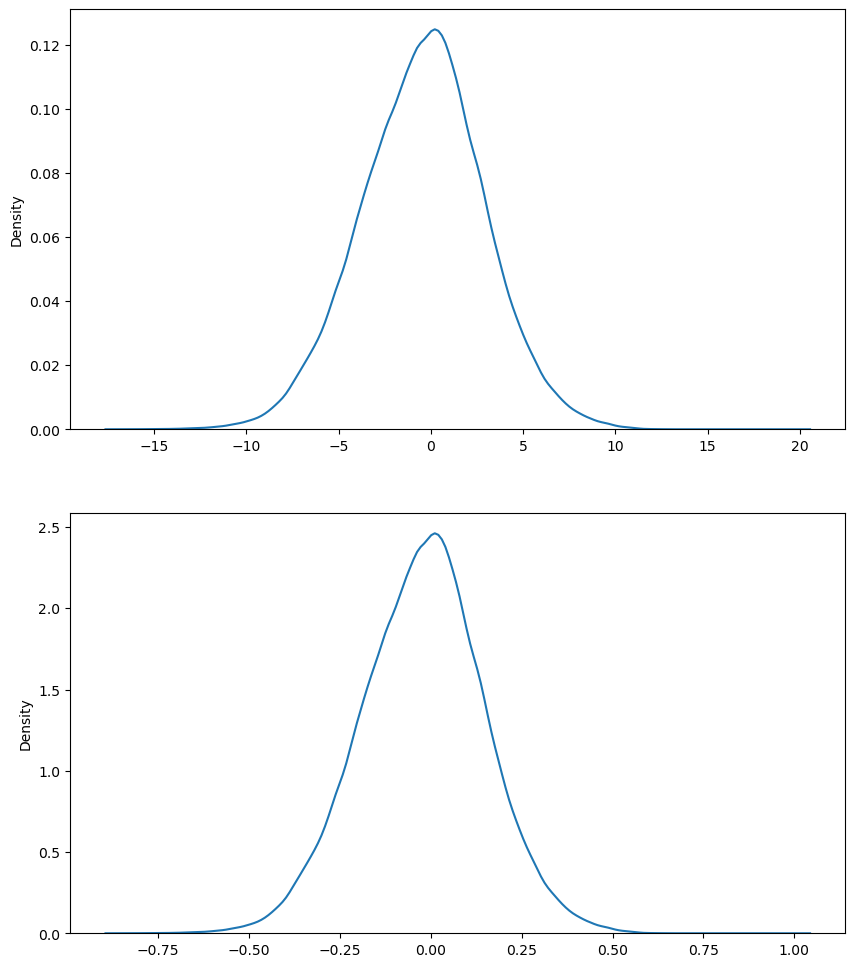

In [67]:
fig, ax = plt.subplots(2, 1, figsize = (10, 12))
sample = sample_vals['v']
sns.kdeplot(data=sample, ax=ax[0])
print(len(sample))

sns.kdeplot(data=(sample - np.abs(sample).min())/np.abs(sample).max(), ax=ax[1])

### Explore iMERG data

In [1]:
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
from calendar import monthrange
import os
import sys
from pathlib import Path
from datetime import datetime
from glob import glob

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from cgan.data import get_imerg_path, DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE

In [3]:
import netCDF4

def load_hdfs5_file(fp, group_name='Grid'):
    
    
    ncf = netCDF4.Dataset(fp, diskless=True, persist=False)
    nch = ncf.groups.get(group_name)
    ds = xr.open_dataset(xr.backends.NetCDF4DataStore(nch))
    
    return ds

def load_imerg_hourly(year, month, day, hour, imerg_data_dir):
    dt_start = datetime(year, month, day, hour, 0, 0)

    hourly_glob_str = os.path.join(imerg_data_dir, '3B-HHR.MS.MRG.3IMERG.' + dt_start.strftime('%Y%m%d-S%H*'))
    fps = glob(hourly_glob_str)
    
    print(fps)
    assert len(fps) == 2, f'Error: too many files found for glob string {hourly_glob_str}'

    datasets = []
    for fp in fps:
        datasets.append(load_hdfs5_file(fp, 'Grid'))
    concat_ds = xr.concat(datasets, dim='time')
    
    return concat_ds

In [4]:
from datetime import datetime, timedelta

year = 2021
month = 4
day = 30
hour = 23
imerg_data_dir = '/bp1store/geog-tropical/data/Obs/IMERG/half_hourly/final'
latitude_vals=np.arange(-12, 16, 1)
longitude_vals=np.arange(25, 50, 1)

ds = load_imerg_hourly(year, month, day, hour, imerg_data_dir=imerg_data_dir)

ds = ds.sel(lon=longitude_vals, lat=latitude_vals, method='nearest')

In [4]:
latitude_vals=np.arange(-12, 16, 1)
longitude_vals=np.arange(25, 50, 1)


ds = load_imerg_day(2020, 11, 1, latitude_vals=latitude_vals, longitude_vals=longitude_vals)

NameError: name 'load_imerg_day' is not defined

/user/work/uz22147/miniconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


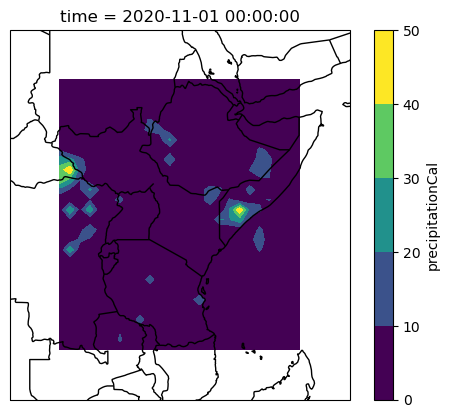

In [103]:
import cartopy.feature as cfeature

buffer = 5

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(longitude_vals) - buffer, max(longitude_vals) + buffer, min(latitude_vals) - buffer, max(latitude_vals) + buffer], crs=ccrs.PlateCarree())
ds['precipitationCal'].isel(time=0).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.BORDERS)


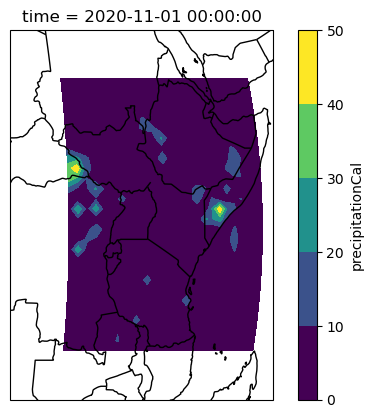

In [109]:
import cartopy.feature as cfeature

buffer = 5

ax = plt.axes(projection=ccrs.Orthographic())
ax.set_extent([min(longitude_vals) - buffer, max(longitude_vals) + buffer, min(latitude_vals) - buffer, max(latitude_vals) + buffer], crs=ccrs.PlateCarree())
ds['precipitationCal'].isel(time=0).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

ax.add_feature(cfeature.BORDERS)

In [114]:
era5_ds = load_era5_day('tp', 2020, 11, 1, latitude_vals=latitude_vals, longitude_vals=longitude_vals)

In [6]:

latitude_vals=np.arange(-12, 16, 1)
longitude_vals=np.arange(25, 50, 1)
era5_vals = []
imerg_vals = []
for month in tqdm(np.arange(1, 13, 1), total=12):
    imerg_ds = load_imerg_day(2019, month, 1, latitude_vals=latitude_vals, longitude_vals=longitude_vals)
    era5_ds = load_era5_day('tp', year=2019, month=month, day=1, latitude_vals=latitude_vals, longitude_vals=longitude_vals)
    
    for lat_val in latitude_vals:
        for lon_val in longitude_vals:
            imerg_val = imerg_ds.sel(lat=lat_val).sel(lon=lon_val)['precipitationCal'].values[0]
            era5_val = era5_ds.sel(latitude=lat_val).sel(longitude=lon_val)['tp'].values[0]
        
            era5_vals.append(era5_val * 1000)
            imerg_vals.append(imerg_val)
            

  0%|          | 0/12 [00:00<?, ?it/s]/user/work/uz22147/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
  8%|▊         | 1/12 [01:01<11:14, 61.35s/it]/user/work/uz22147/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
 17%|█▋        | 2/12 [02:05<10:27, 62.74s/it]/user/work/uz22147/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
 25%|██▌       | 3/12 [03:10<09:37, 64.11s/it]

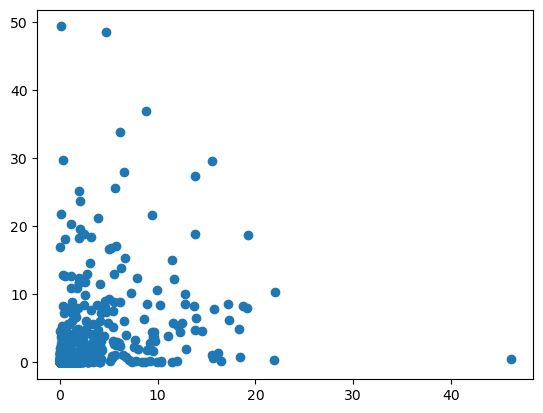

In [123]:
plt.scatter(era5_vals, imerg_vals)
plt.xlabel('ERA5 total preciptation (daily')